# **Introduction**

**About Dataset**

* **Breast cancer** is one of the **most common** causes of death among **women worldwide**. Early detection helps in reducing the **number of early deaths**. The data reviews the **medical images of breast cancer** using ultrasound scan. **Breast Ultrasound Dataset** is categorized into **three classes** $:$ **normal, benign, and malignant images**. **Breast ultrasound images** can produce great results in **classification, detection, and segmentation** of breast cancer when combined with machine learning. 

* The data collected at baseline include **breast ultrasound images among women** in ages between 25 and 75 years old. This data was collected in **2018**. The number of patients is **600 female patients**. The dataset consists of **780 images** with an **average image size of 500*500 pixels**. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into **three classes, which are normal, benign, and malignant**.

**Approach**

* **AttentionUNet/UNet** is the best know model for **Multi-Class Segmentation**, thats why we will be creating a **Attention UNet Model**.
* As the **image Dataset** is **old**, please **do not use it for any new medical operations**.
* All the images are of 500 X 500 pixels, **Kaggle RAM** wil not be enough so we will be resizing the Image to **256 X 256 pixels**.

**Model Architecture**

* The Model will consist of a **Encoder Block, Decoder Block and a Attention Gate.**

# **Imports**

In [51]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

In [2]:
# common
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks 
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU

# **Data**

In [3]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img
    
    return images

In [4]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [5]:
SIZE = 256

In [6]:
root_path = 'C://Users/Muruganantham J/Documents/Research/Codes/BreastCancer_UNET/BrEaST-Lesions_USG-images_and_masks/'
classes = sorted(os.listdir(root_path))
classes

['tumor']

In [7]:
single_mask_paths = sorted([sorted(glob(root_path + name + "/*_tumor.png")) for name in classes])


In [ ]:
single_mask_paths

In [9]:
image_paths = []
mask_paths = []
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_tumor','')
        image_paths.append(img_path)
        mask_paths.append(path)

In [ ]:
image_paths

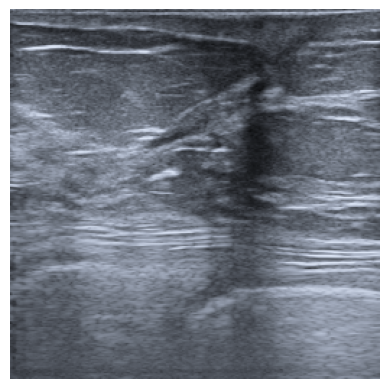

In [11]:
show_image(load_image(image_paths[0], SIZE))

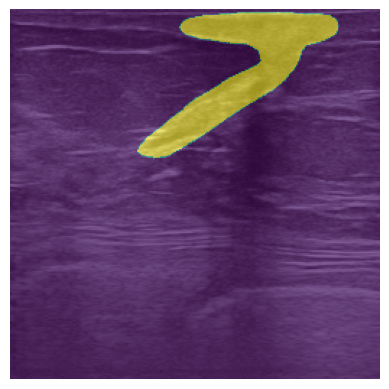

In [12]:
show_mask(load_image(image_paths[0], SIZE), load_image(mask_paths[0], SIZE)[:,:,0], alpha=0.6)

## **Approach**

Below here I have explained my strategy to tackel the multiple mask Images.

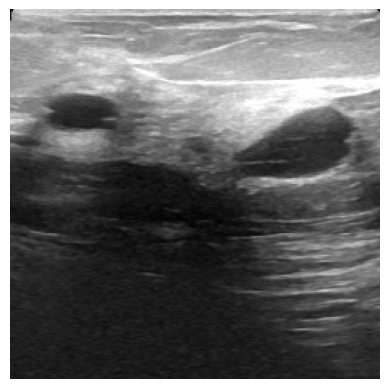

In [13]:
show_image(load_image('C://Users/Muruganantham J/Documents/Research/Codes/BreastCancer_UNET/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))

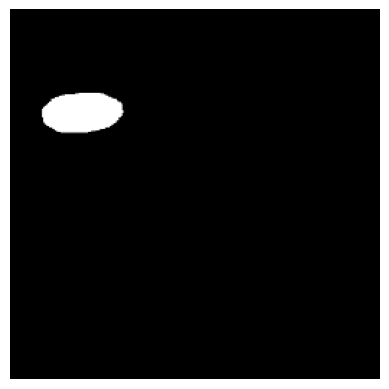

In [14]:
show_image(load_image('C://Users/Muruganantham J/Documents/Research/Codes/BreastCancer_UNET/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE))

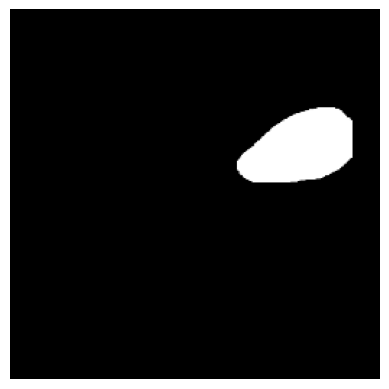

In [29]:
show_image(load_image('C://Users/Muruganantham J/Documents/Research/Codes/BreastCancer_UNET/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE))

I don't want the data this way, as both the masks belongs to the same class. A better idea can be to merge both these images

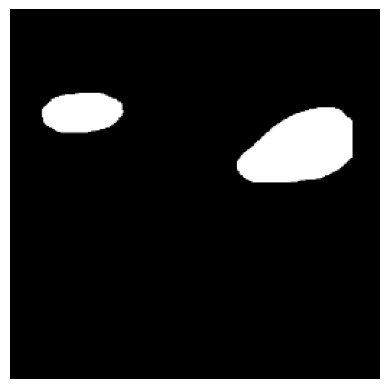

In [31]:
img = np.zeros((1,SIZE,SIZE,3))
mask1 = load_image('C://Users/Muruganantham J/Documents/Research/Codes/BreastCancer_UNET/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE)
mask2 = load_image('C://Users/Muruganantham J/Documents/Research/Codes/BreastCancer_UNET/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE)

img = img + mask1 + mask2
img = img[0,:,:,0]
show_image(img, cmap='gray')

We first merged them and them simple used the 1st channel because that is enough.

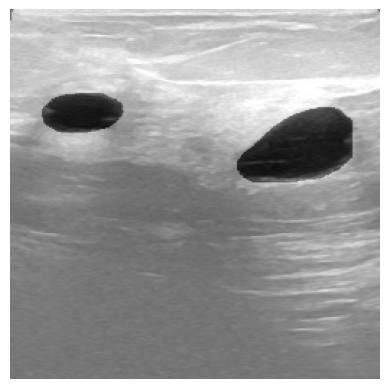

In [32]:
show_image(load_image('C://Users/Muruganantham J/Documents/Research/Codes/BreastCancer_UNET/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='binary', alpha=0.4)
plt.axis('off')
plt.show()

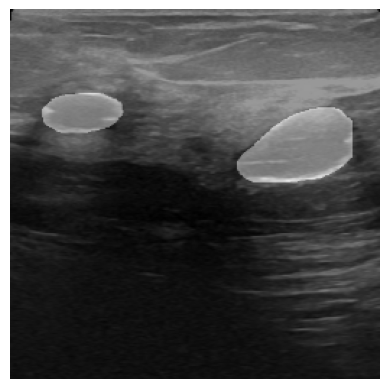

In [34]:
show_image(load_image('C://Users/Muruganantham J/Documents/Research/Codes/BreastCancer_UNET/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='gray', alpha=0.4)
plt.axis('off')
plt.show()

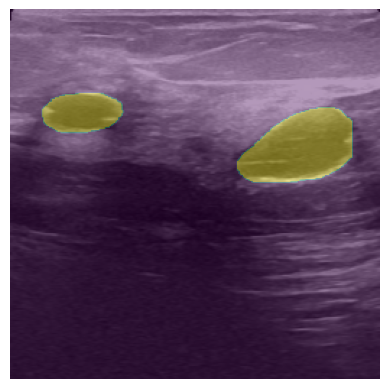

In [35]:
show_image(load_image('C://Users/Muruganantham J/Documents/Research/Codes/BreastCancer_UNET/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, alpha=0.4)
plt.axis('off')
plt.show()

This is how it looks with different cmaps. But you can drop them as then are very less in number (i.e 16) and this will not affect training much.

## **Data Work**

In [15]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

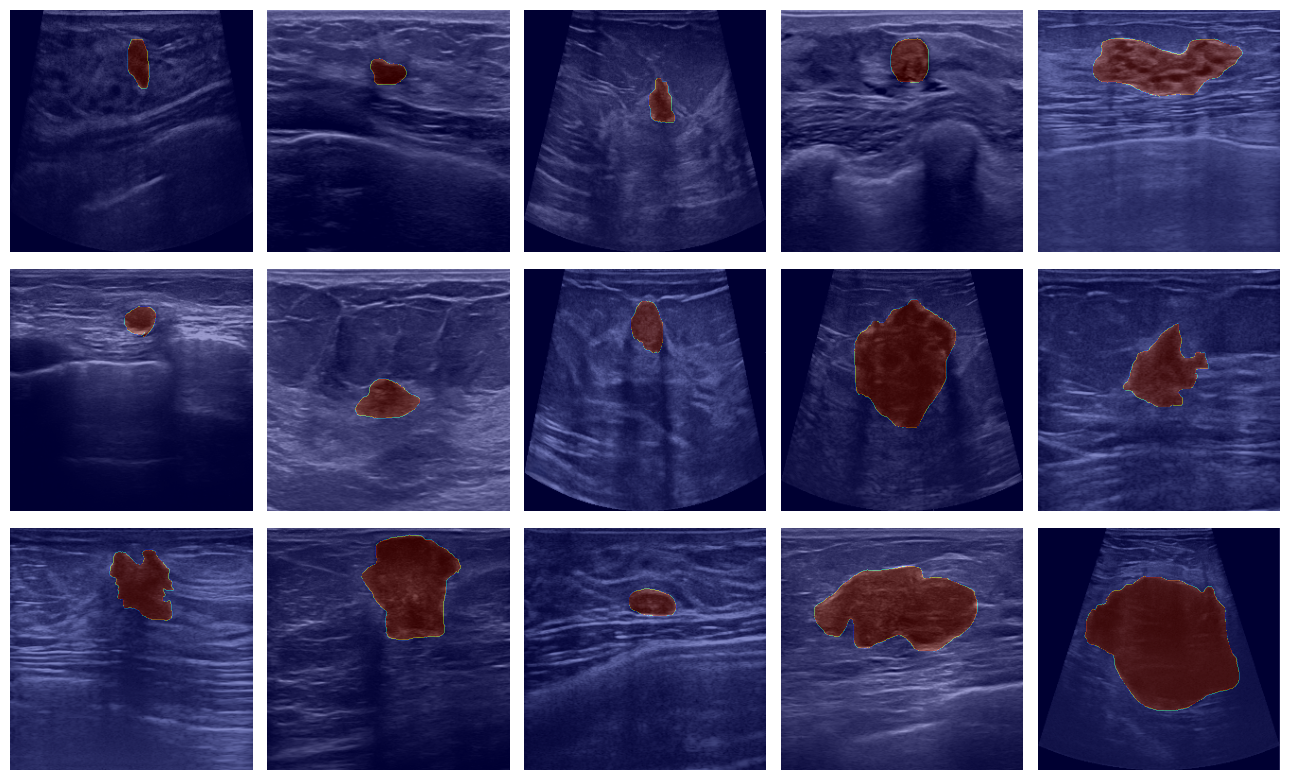

In [46]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
plt.tight_layout()
plt.show()

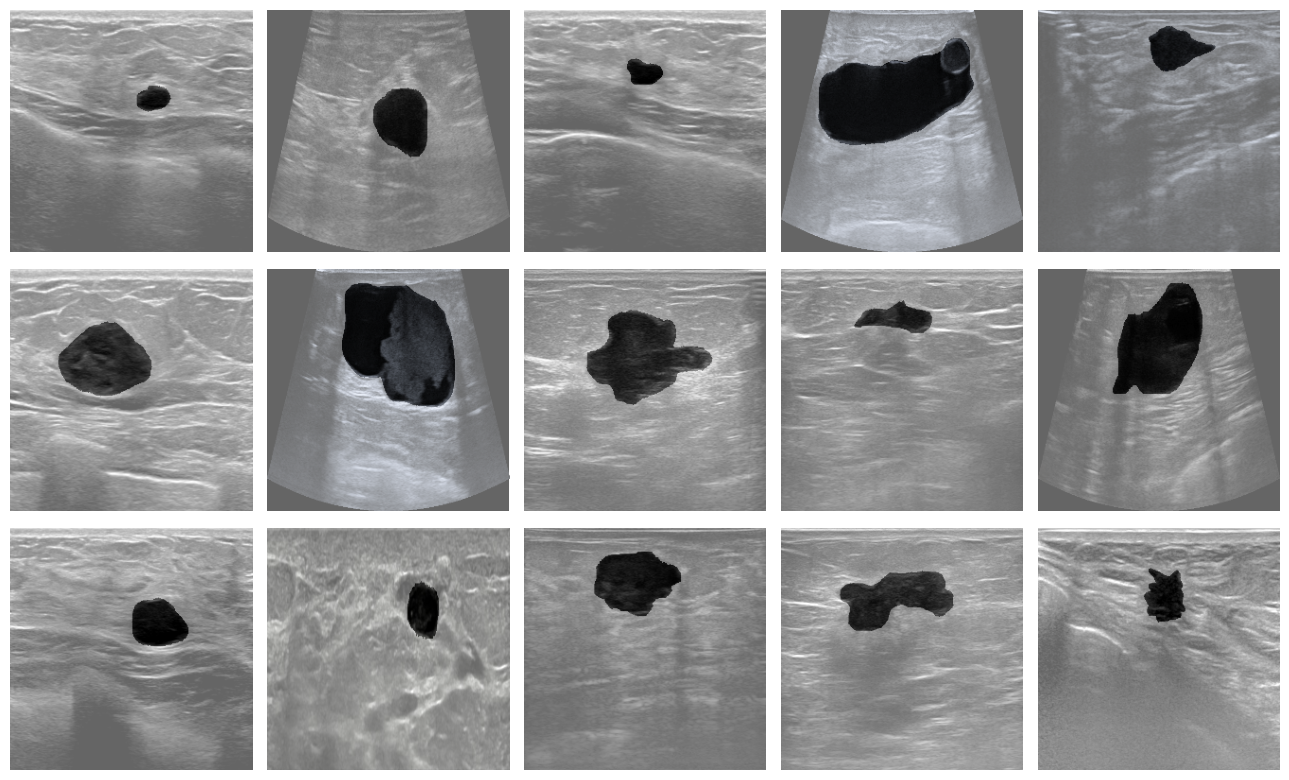

In [47]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='binary')
plt.tight_layout()
plt.show()

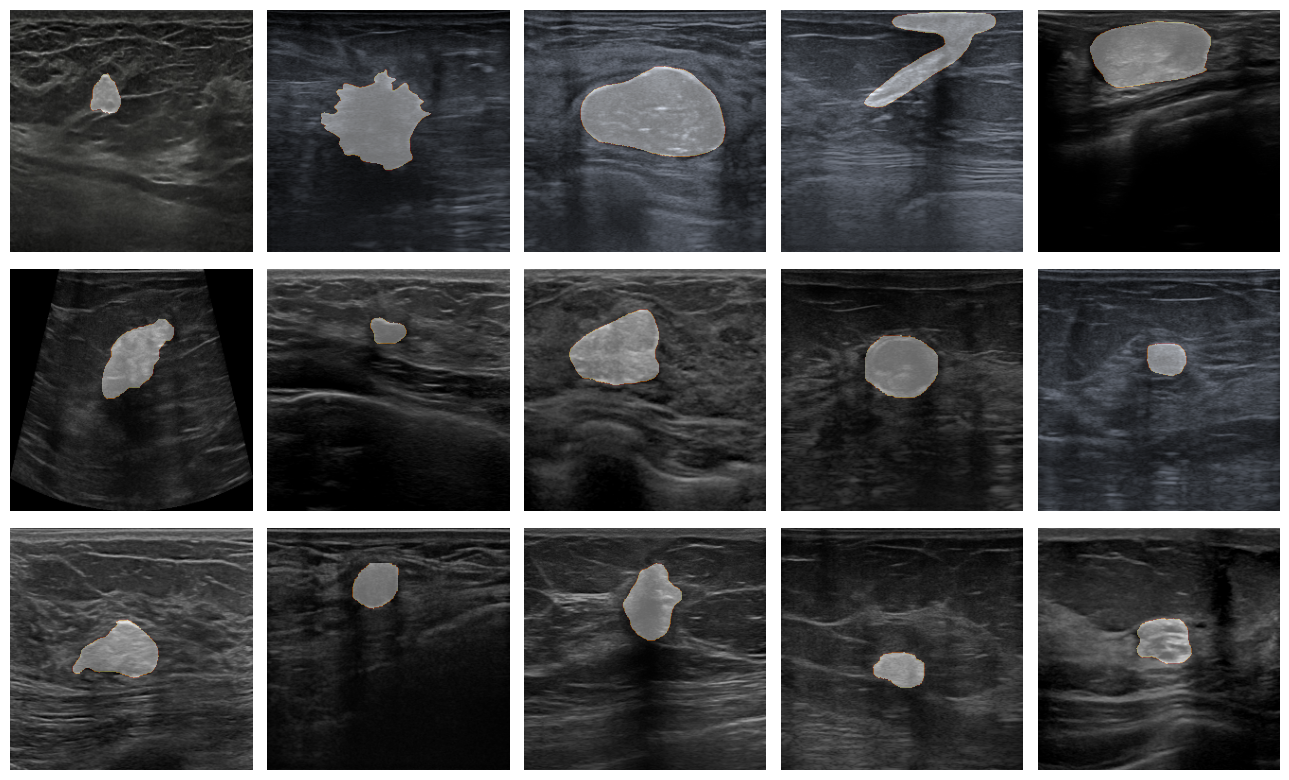

In [48]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='afmhot')
plt.tight_layout()
plt.show()

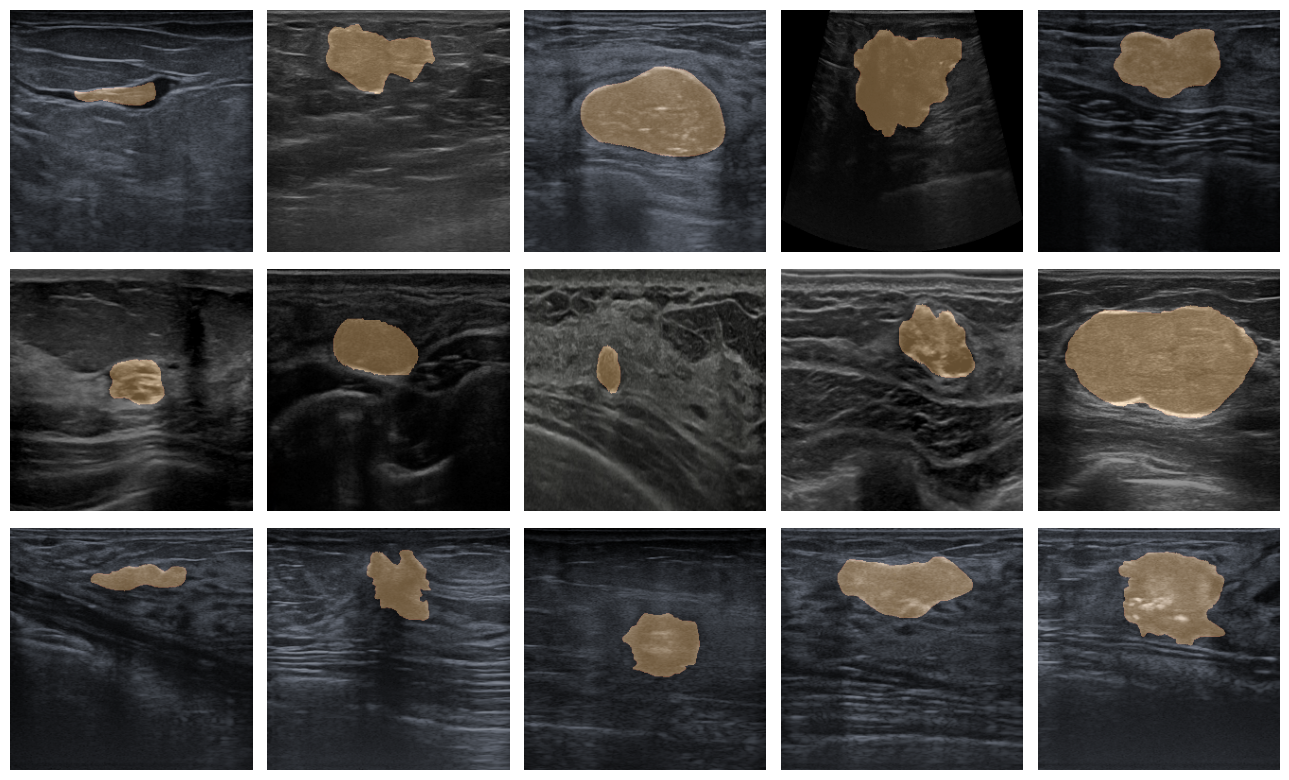

In [19]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

# **Encoder**

In [52]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }
    def build(self, input_shape):
    # Define trainable variables like weights and biases here
    # You might also need to perform shape calculations based on input_shape
    # ...
        super(EncoderBlock, self).build(input_shape)

# **Decoder**

In [21]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }


# **Attention Gate**

In [35]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

# **Custom Callback**

In [36]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        id = np.random.randint(200)
        exp = GradCAM()
        image = images[id]
        mask = masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])
        cam = exp.explain(
            validation_data=(image[np.newaxis,...], mask),
            class_index=1,
            layer_name='Attention4',
            model=self.model
        )

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')

        plt.subplot(1,3,3)
        show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()

# **Attention UNet**

In [37]:
# Inputs
input_layer = Input(shape=images.shape[-3:])

# Encoder
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output 
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)

# Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)

# Callbacks
cb = [
    ModelCheckpoint("BreastCancerAttentionUNet.keras", save_best_only=True),  # Use .keras extension
    ShowProgress()
]


C:\Users\Muruganantham J\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'encoder_block_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\Muruganantham J\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'encoder_block_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\Muruganantham J\AppData\Roaming\Python\Python312\site-packages\keras\src\la

# **Training**

In [ ]:
# Config Training
BATCH_SIZE = 8
SPE = len(images)//BATCH_SIZE

# Training
results = model.fit(
    images, masks,
    validation_split=0.2,
    epochs=20, # 15 will be enough for a good Model for better model go with 20+
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE,
   
)



In [38]:
# Config Training
BATCH_SIZE = 8

# Calculate steps per epoch (assuming your 'images' data is a list or NumPy array)
SPE = len(images) // BATCH_SIZE  # Integer division for number of batches

# Training
results = model.fit(
    images, masks,
    validation_split=0.2,
    epochs=20,  # Adjust epochs as needed, higher for potentially better models
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE,

)

Epoch 1/20
26/31 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - IoU: 0.4715 - accuracy: 0.7699 - loss: 0.8175

C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


31/31 ━━━━━━━━━━━━━━━━━━━━ 159s 5s/step - IoU: 0.4709 - accuracy: 0.7881 - loss: 0.7552 - val_IoU: 0.4627 - val_accuracy: 0.9227 - val_loss: 0.4821
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - IoU: 0.4631 - accuracy: 0.9237 - loss: 0.2456 - val_IoU: 0.4627 - val_accuracy: 0.9227 - val_loss: 0.3897
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - IoU: 0.4684 - accuracy: 0.9346 - loss: 0.2007 - val_IoU: 0.4627 - val_accuracy: 0.9227 - val_loss: 0.3473
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 146s 5s/step - IoU: 0.4659 - accuracy: 0.9293 - loss: 0.2101 - val_IoU: 0.4627 - val_accuracy: 0.9227 - val_loss: 0.3412
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - IoU: 0.4706 - accuracy: 0.9392 - loss: 0.1789 - val_IoU: 0.4627 - val_accuracy: 0.9228 - val_loss: 0.3598
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - IoU: 0.4668 - accuracy: 0.9312 - loss: 0.1903 - val_IoU: 0.4627 - val_accuracy: 0.9227 - val_loss: 0.2131
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 146s 5s/step - IoU:

**Observations :**

* After **12 epochs** model started outputting what we needed.
* The model was easily able to detect **black round spots but fails when the shape is irregular**(Not the case with current model because it is trained with hight SPE). 

* It also gets confused between the dark areas, which makes sense.

---
**Suggestion :**
* Do training in chunks of **20 Epochs**, this will give you a good control **over model and the model will also perform well**.

* Here the model is trained on 17 + 17 + 17 = 51 Epochs.

* If you give the model a closer look n different images you will find that the model fails at some images, but I can garantee that 9/10 such images would be so tough that even a human will not be a able to detect as many parts of the image look the same.


# **Evaluation**

In [39]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

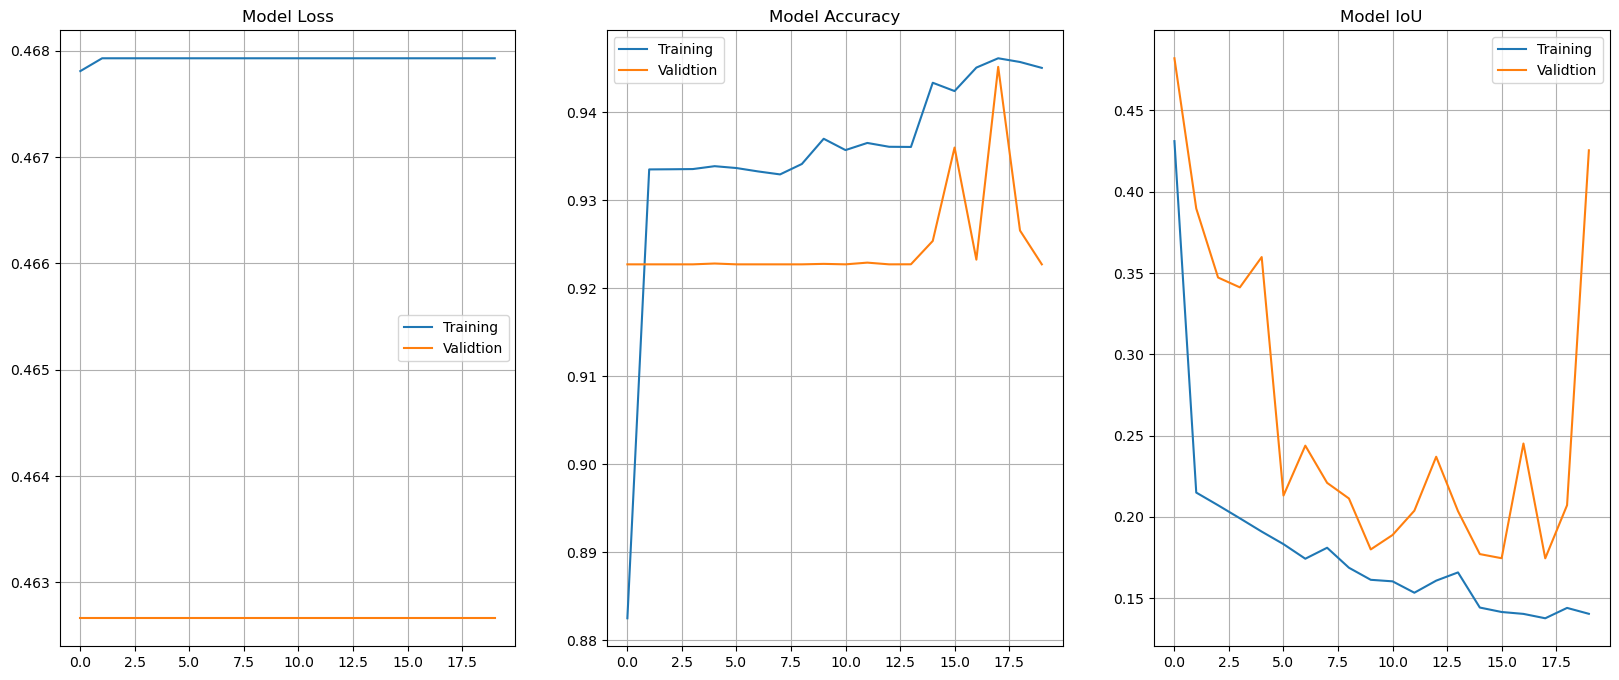

In [40]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

Suprisingly the results on **Validation Data** are **way better** than the results on **Trainind Data** on **IoU**, this may indicate that the **model can perform way better** than what it can do at the current point. The **Loss is not Perfect** it increases in the last but the model constructions are loooking perfect as this point, that's why **I believe in what I see**. This model seems promising, let's try it on some Images.

In [ ]:
loaded_model = tf.keras.models.load_model("model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


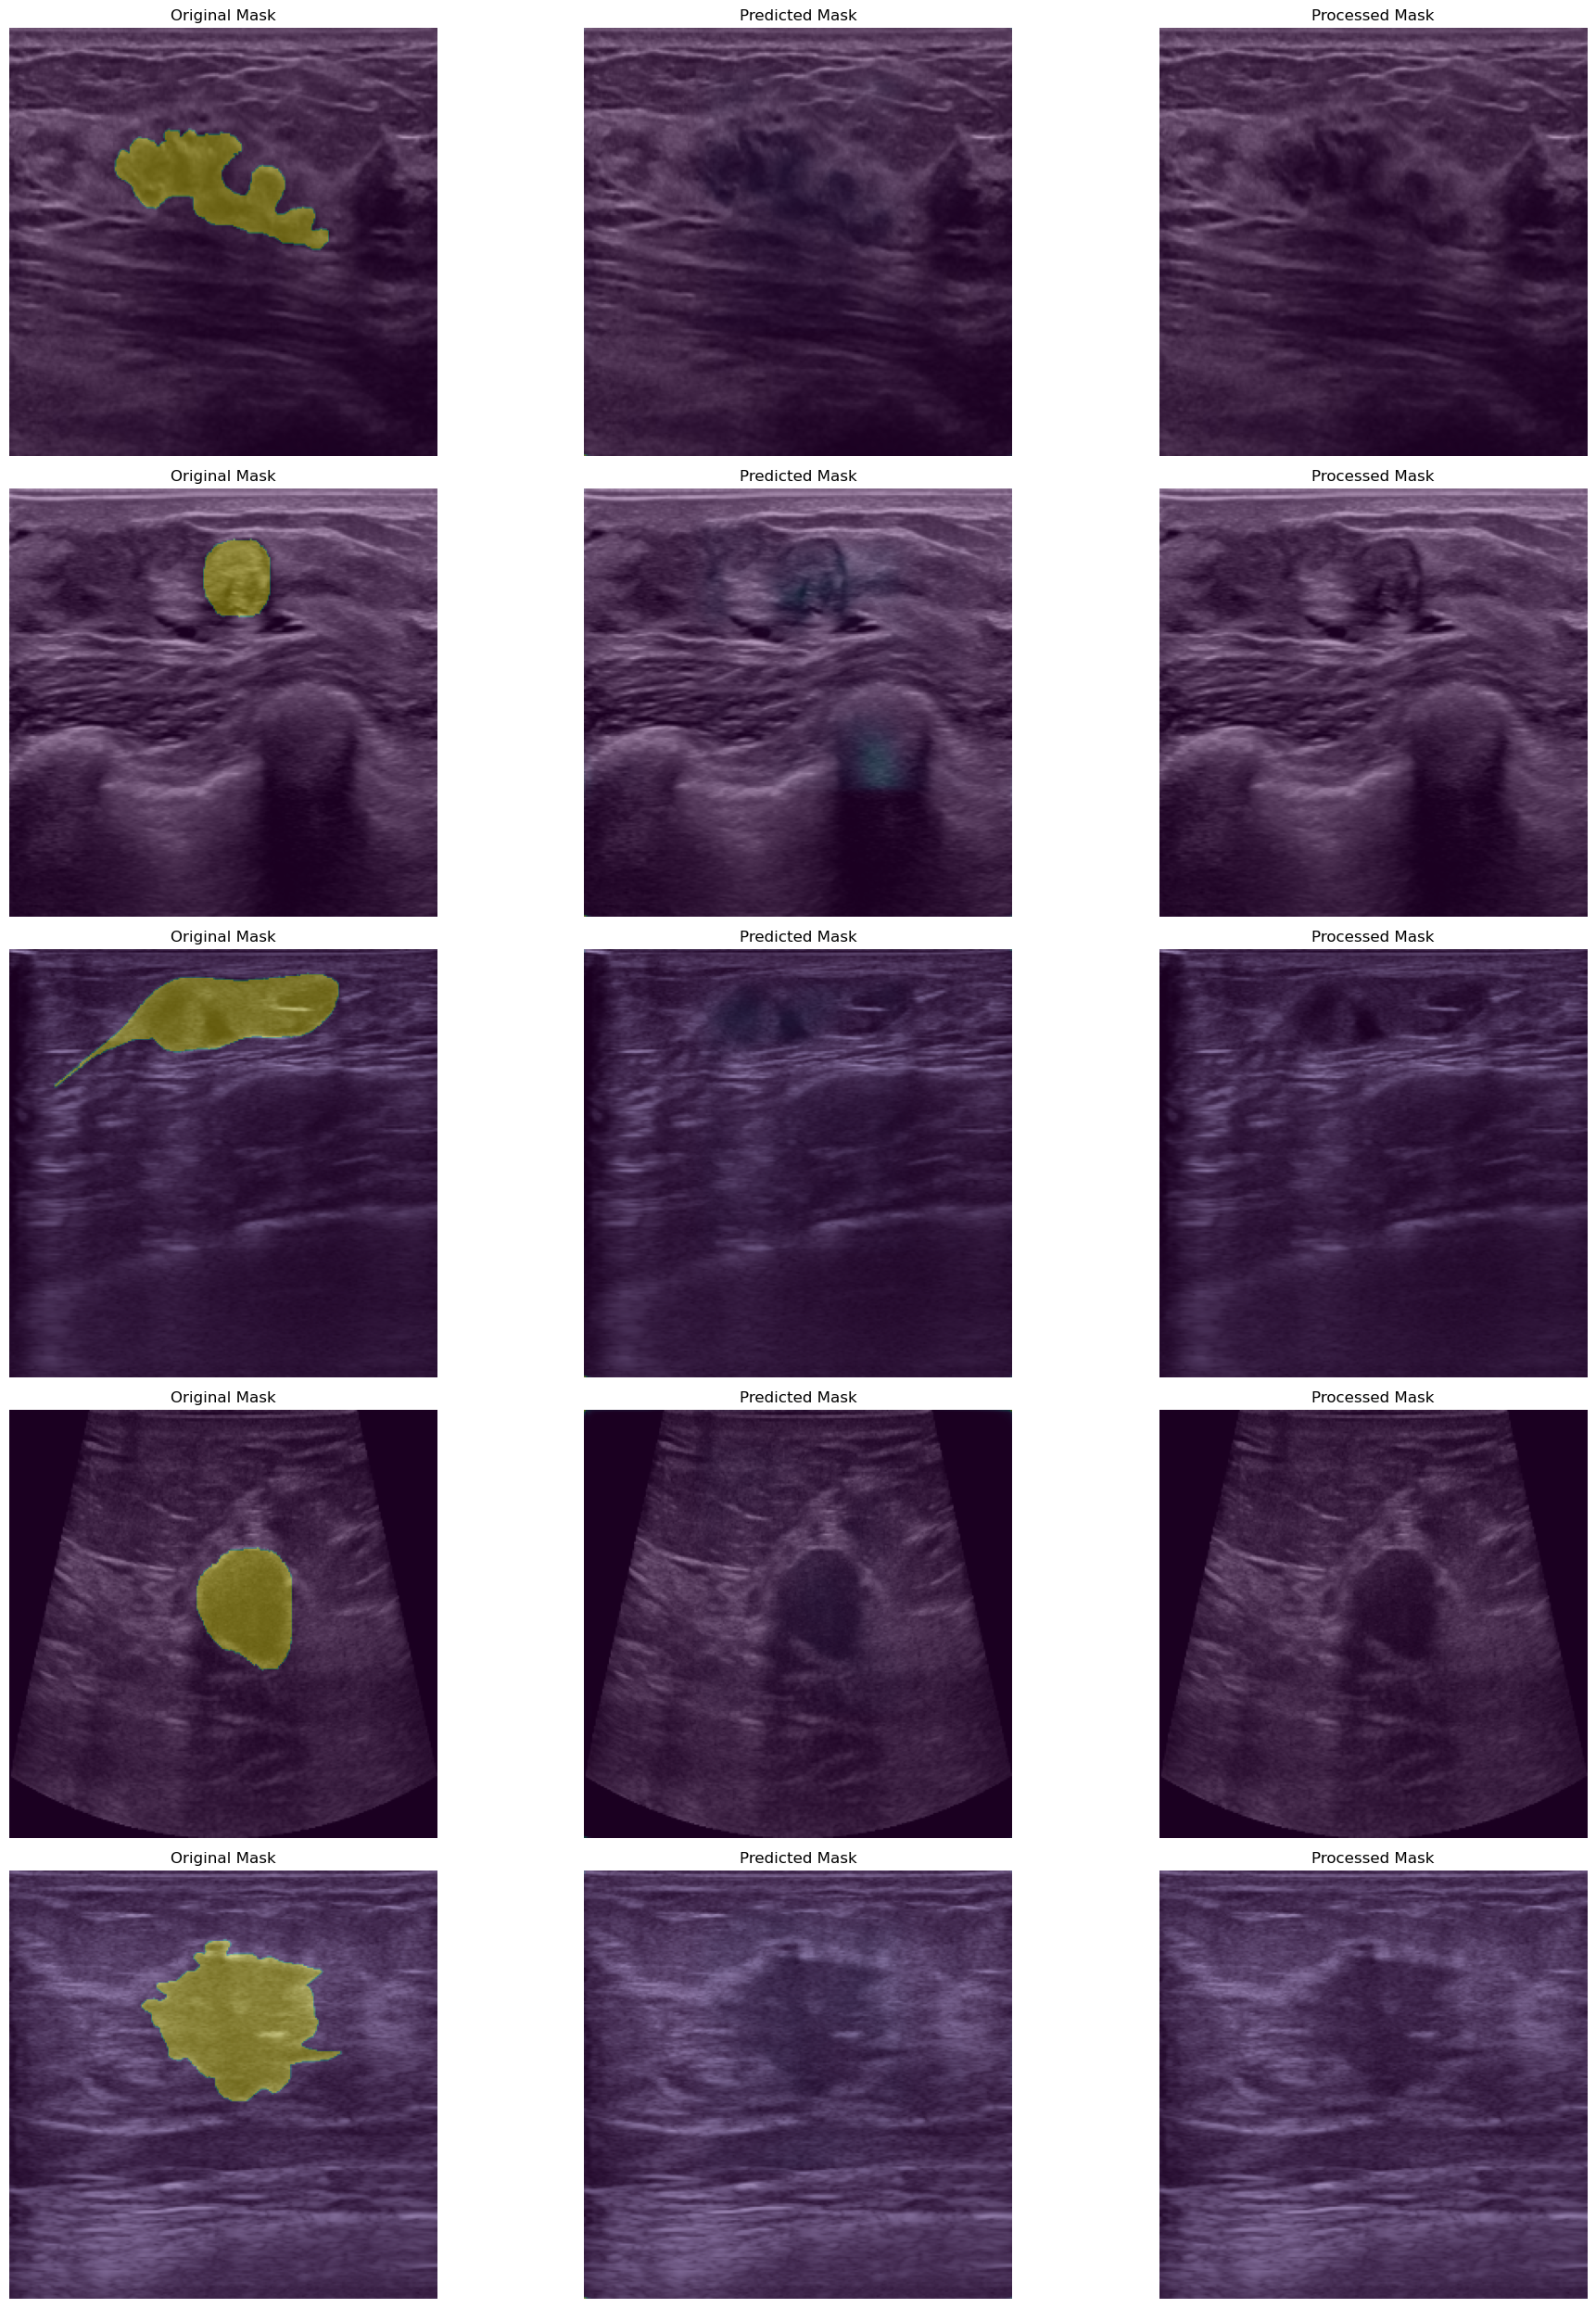

In [59]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

The results totally convincing. If you have any suggestions please let me know 👍. **Thanks !!**